In [ ]:
!pip install tf-keras

In [ ]:
!pip install transformers

In [ ]:
!pip install nltk

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn wordcloud

In [ ]:
!pip install streamlit boto3 psycopg2-binary sqlalchemy

In [ ]:
!pip install torch tensorflow transformers datasets

In [ ]:
pip install emoji

In [ ]:
import os
import sys
import time
import json
import joblib
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import nltk
import re
import string
import emoji
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import RobertaTokenizerFast, TFRobertaModel
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TextClassificationPipeline,
    Trainer,
    TrainingArguments,
    pipeline
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load training data
train_df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "amananandrai/ag-news-classification-dataset",
    "train.csv"
)

# Load testing data
test_df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "amananandrai/ag-news-classification-dataset",
    "test.csv"
)

print("Train sample:", train_df.head())
print("Test sample:", test_df.head())

/tmp/ipython-input-4106562484.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  train_df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'ag-news-classification-dataset' dataset.


/tmp/ipython-input-4106562484.py:12: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  test_df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'ag-news-classification-dataset' dataset.
Train sample:    Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  
Test sample:    Class Index                                              Title  \
0            3                  Fears for T N pension after talks   
1    

Class Index


Consists of class ids 1-4 where

 1-World,

 2-Sports,

  3-Business,
  
  4-Sci/Tech

In [ ]:
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [ ]:
df.set_index('Class Index', inplace=True)

# Concatenate 'Title' and 'Description' into a single text field
df['text'] = df['Title'] + " " + df['Description']

# Adjust labels: convert to 0-based index
df['label'] = df.index-1

# Preview the processed DataFrame
print(df.head())

                                                         Title  \
Class Index                                                      
3            Wall St. Bears Claw Back Into the Black (Reuters)   
3            Carlyle Looks Toward Commercial Aerospace (Reu...   
3              Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            Iraq Halts Oil Exports from Main Southern Pipe...   
3            Oil prices soar to all-time record, posing new...   

                                                   Description  \
Class Index                                                      
3            Reuters - Short-sellers, Wall Street's dwindli...   
3            Reuters - Private investment firm Carlyle Grou...   
3            Reuters - Soaring crude prices plus worries\ab...   
3            Reuters - Authorities have halted oil export\f...   
3            AFP - Tearaway world oil prices, toppling reco...   

                                                          text  label  
Cl

Exploratory Data Analysis (EDA)

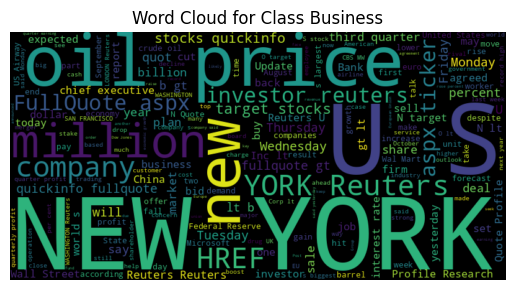

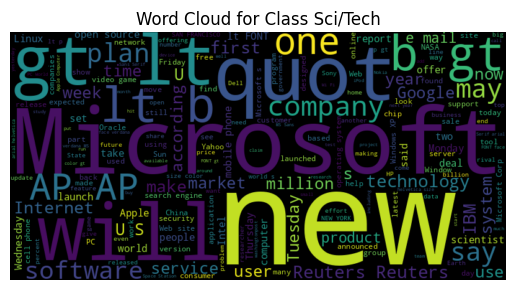

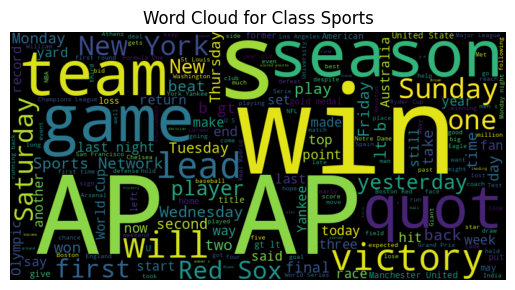

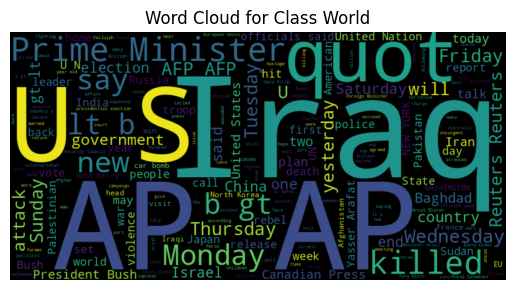

In [ ]:
 # Generate word clouds for each category


import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Class distribution
label_names = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# Use the combined df and 'label_name' column
# Remove the line below which causes the error
# train_df["label_name"] = train_df["label"].map(label_names)

# Word cloud per class
for label in df['label'].unique():
    # Ensure 'clean_text' column exists or use 'text' if 'clean_text' is not yet created
    # Assuming 'text' column is the one to use for now as 'clean_text' is not in the notebook state
    text = ' '.join(df[df['label'] == label]['text'])
    wc = WordCloud(width=800, height=400).generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Class {label_names[label]}') # Use label_names to show meaningful titles
    plt.show()

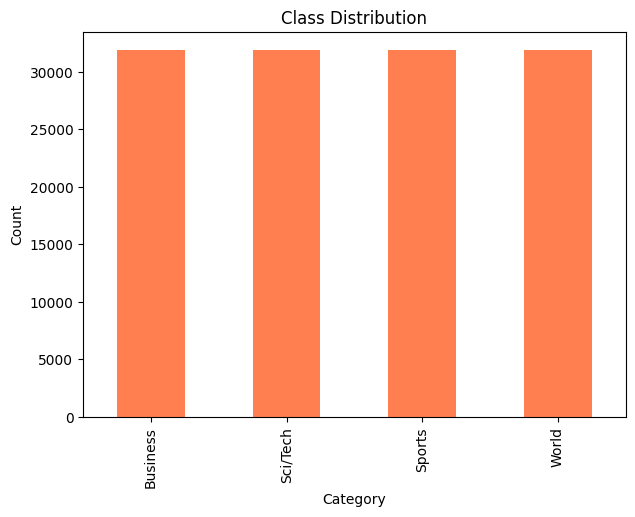

In [ ]:
import matplotlib.pyplot as plt

# Corrected label names dictionary
label_names = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# Use the combined df and 'label' column
df["label_name"] = df["label"].map(label_names)

plt.figure(figsize=(7,5))
df["label_name"].value_counts().plot(kind="bar", color="coral")
plt.title("Class Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


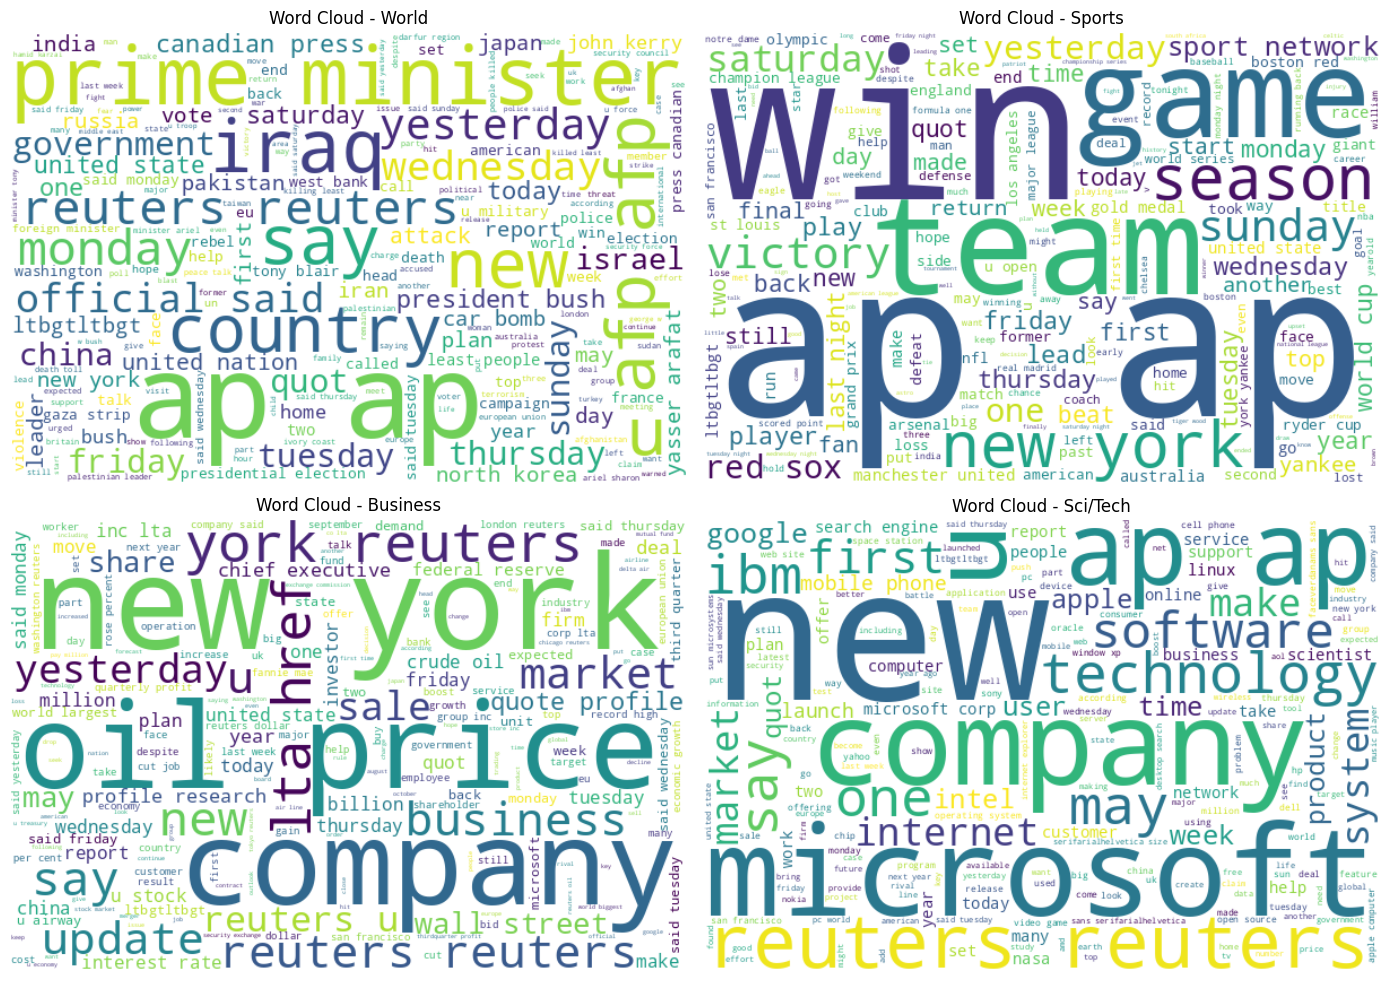

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import re
import string
import emoji
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if not already downloaded
try:
    nltk.data.find('corpora/stopwords')
except Exception: # Catch a more general exception
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except Exception: # Catch a more general exception
    nltk.download('wordnet')


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str): # Handle potential non-string inputs
        return ""
    text = text.lower() # Lowercase the text
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'\@\w+|\#','', text) # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]','', text) # Remove punctuation
    text = emoji.replace_emoji(text, replace='') # Remove emojis
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = text.strip() # Remove leading/trailing whitespace
    text = ' '.join(word for word in text.split() if word not in stop_words) # Remove stop words
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split()) # Lemmatize words
    return text

# Apply the cleaning function to create the 'clean_text' column
df['clean_text'] = df['text'].apply(clean_text)


# Define label names
label_names = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

plt.figure(figsize=(14, 10))
for i, (lab, cat) in enumerate(label_names.items(), start=1):
    plt.subplot(2, 2, i)
    # Use the combined df and 'clean_text' column
    text = " ".join(df[df["label"] == lab]["clean_text"].dropna()) # Use clean_text and handle potential NaNs
    wc = WordCloud(width=600, height=400, background_color="white").generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.title(f"Word Cloud - {cat}")
    plt.axis("off")
plt.tight_layout()
plt.show()

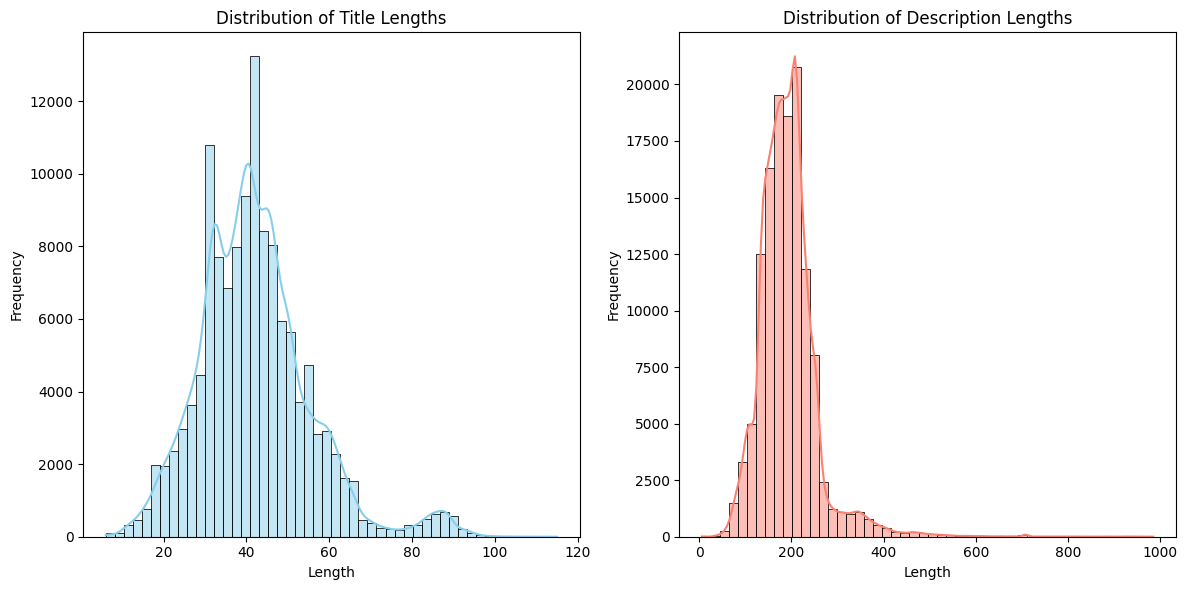

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the length of 'Title' and 'Description'
df['title_length'] = df['Title'].apply(len)
df['description_length'] = df['Description'].apply(len)

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['title_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Title Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['description_length'], bins=50, kde=True, color='salmon')
plt.title('Distribution of Description Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

/tmp/ipython-input-2507913448.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  freq_matrix = freq_matrix.fillna(0).astype(int)


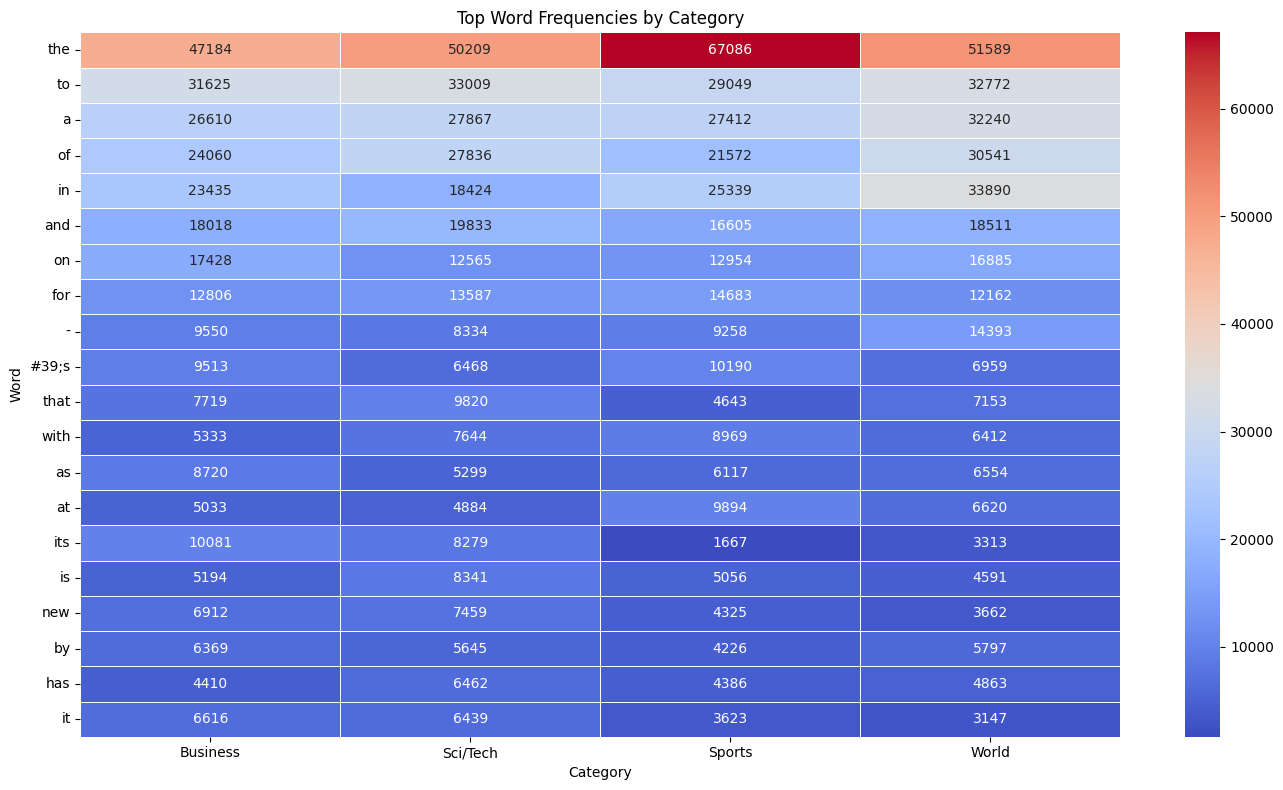

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Create a mapping from label index to label name
label_map = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Sci/Tech'
}

# Add a new column 'label_name' to the DataFrame
df['label_name'] = df['label'].map(label_map)

#  Create a word frequency dictionary per category
category_words = df.groupby('label_name')['text'].apply(lambda x: ' '.join(x).lower().split())

#  Count word frequencies per category
category_freqs = {}
for label, words in category_words.items():
    category_freqs[label] = Counter(words)

#  Get top N words across all categories
top_n = 20
all_words = sum(category_freqs.values(), Counter())
top_words = [word for word, _ in all_words.most_common(top_n)]

#  Build frequency matrix
freq_matrix = pd.DataFrame(index=top_words, columns=category_freqs.keys())
for label in category_freqs:
    for word in top_words:
        freq_matrix.loc[word, label] = category_freqs[label][word]

# Fill NaNs with 0 and convert to int
freq_matrix = freq_matrix.fillna(0).astype(int)

#  Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(freq_matrix, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5)
plt.title('Top Word Frequencies by Category')
plt.xlabel('Category')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

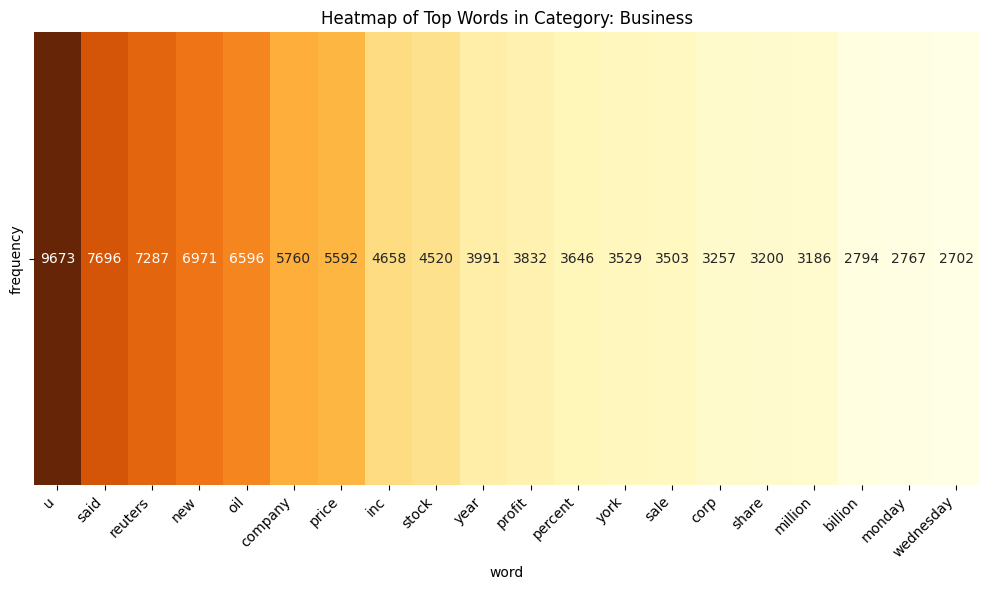

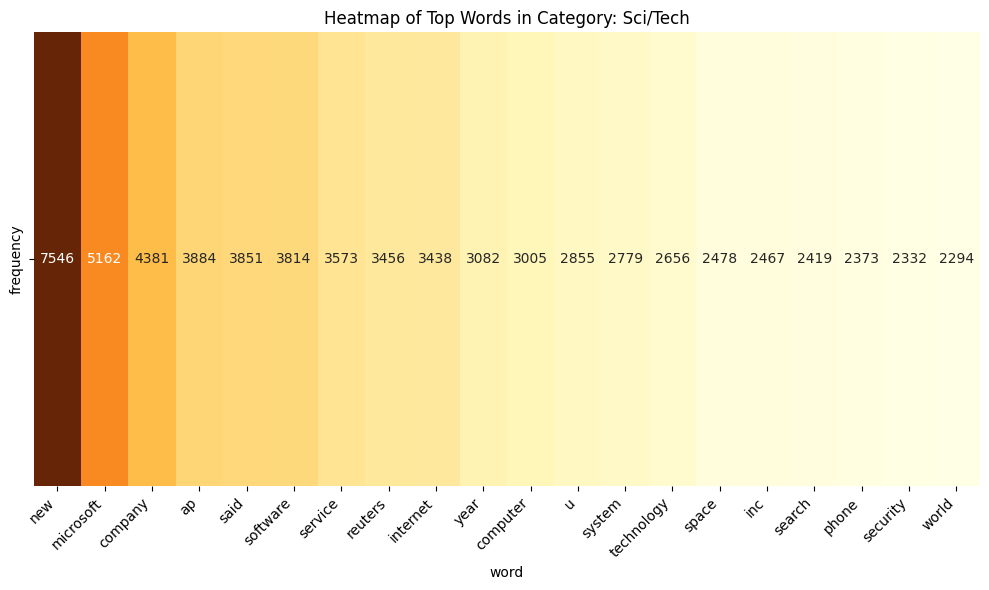

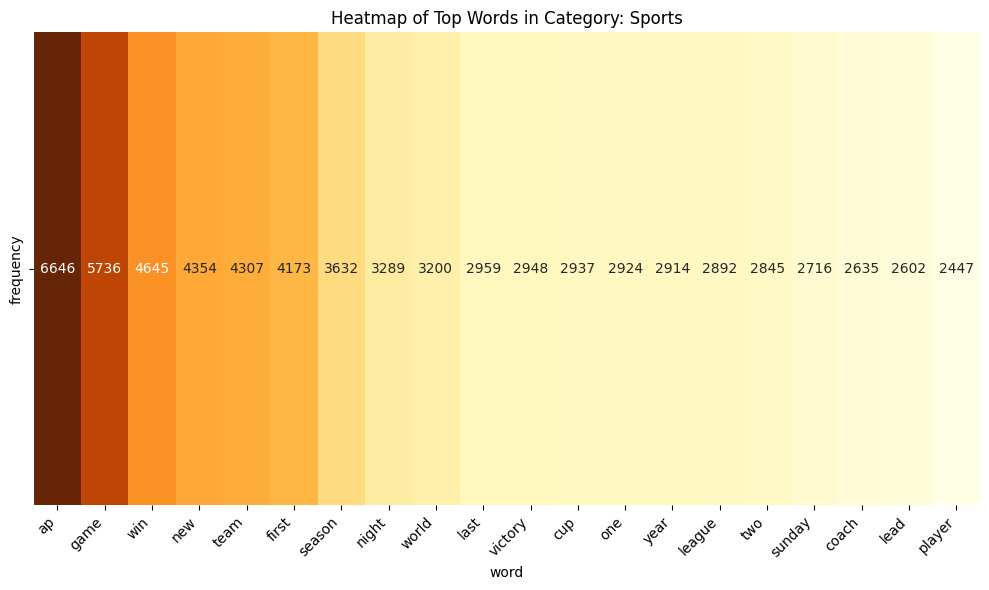

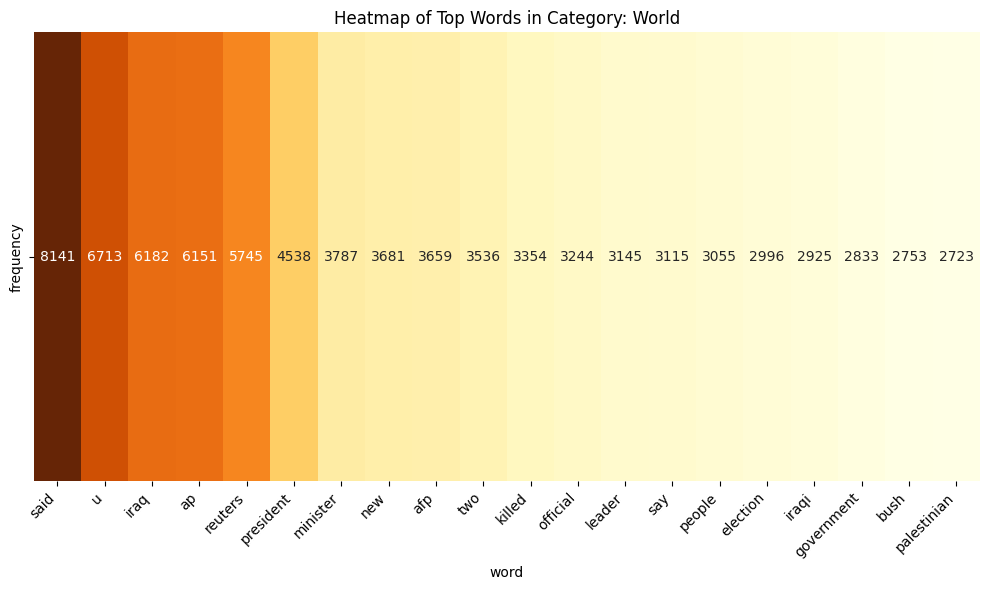

In [ ]:


#  Prepare word frequency per label
label_groups = df.groupby('label_name')['clean_text'].apply(lambda x: ' '.join(x).lower().split())

#  Loop through each label and generate heatmap
for label, words in label_groups.items():
    # Count word frequencies
    word_freq = Counter(words)
    top_words = word_freq.most_common(20)  # Top 20 words

    # Convert to DataFrame
    freq_df = pd.DataFrame(top_words, columns=['word', 'frequency']).set_index('word')

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(freq_df.T, cmap='YlOrBr', annot=True, fmt='d', cbar=False)
    plt.title(f'Heatmap of Top Words in Category: {label}')
    plt.yticks(rotation=90)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



In [ ]:
# Calculate the word count for each entry in the 'clean_text' column
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# Calculate the average word count
avg_word_count = round(df['word_count'].mean())
print(avg_word_count)

25


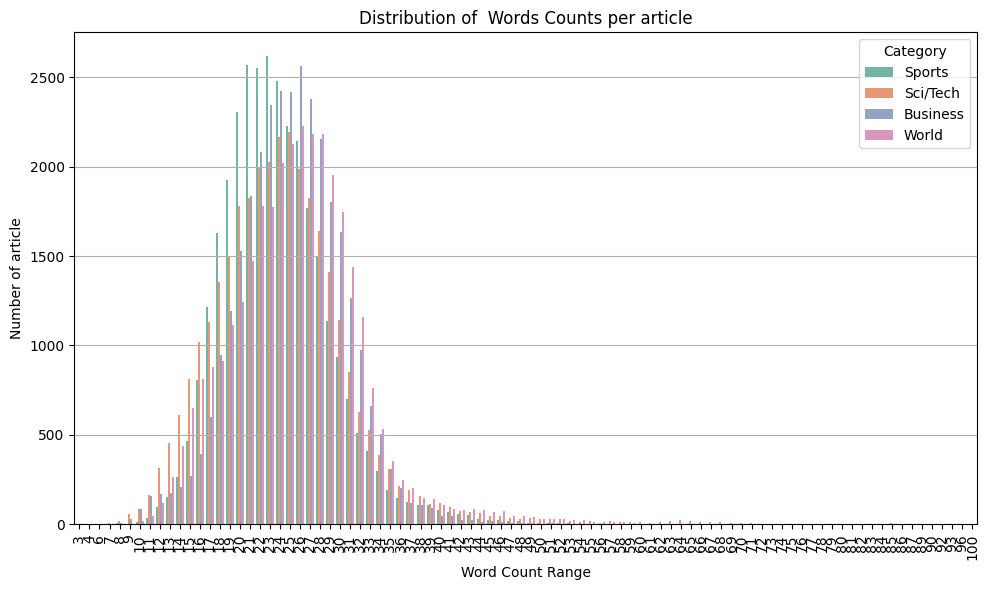

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='word_count', hue='label_name', palette='Set2')
plt.title('Distribution of  Words Counts per article')
plt.xlabel('Word Count Range')
plt.ylabel('Number of article')
plt.legend(title='Category')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

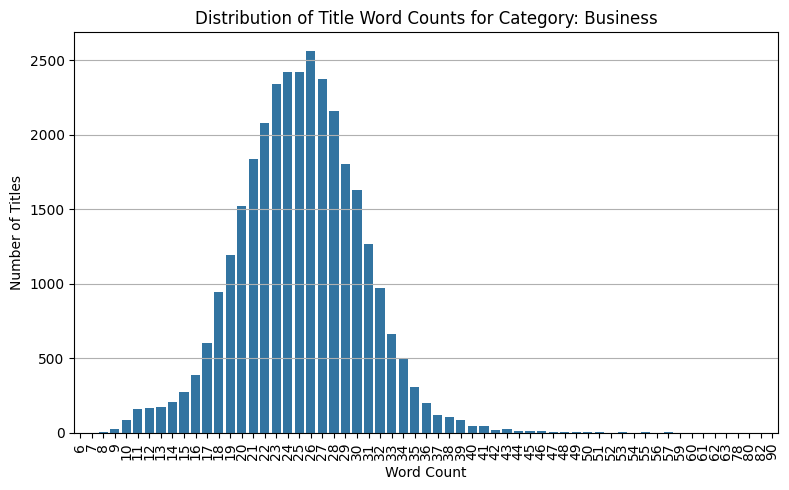

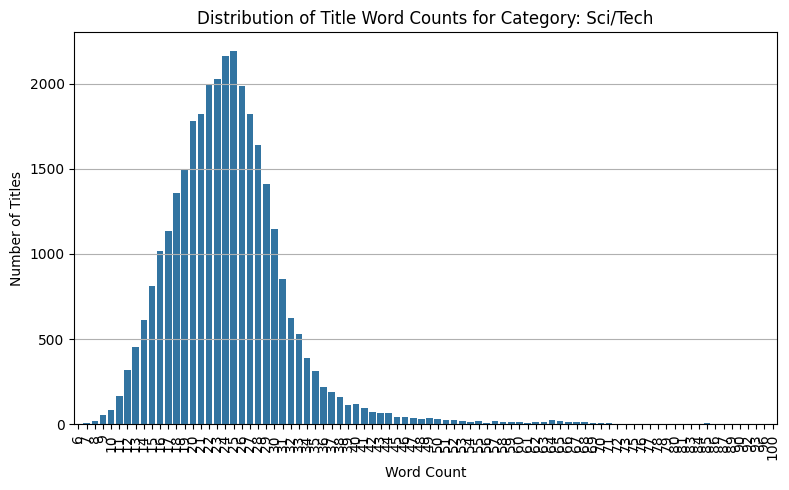

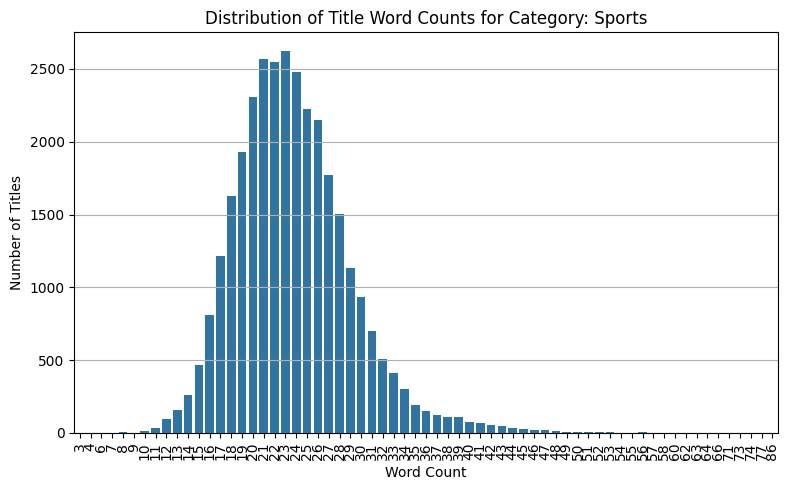

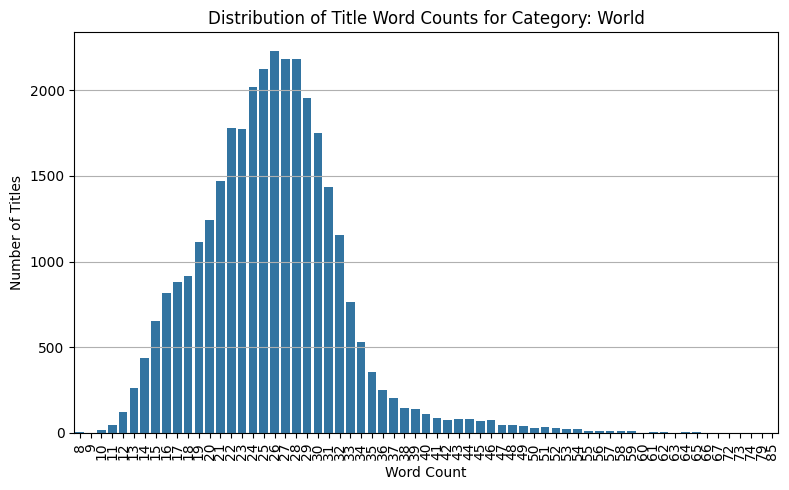

In [ ]:
# Get unique labels
unique_labels = df['label_name'].unique()

# Loop through each label and plot word count distribution
for label in unique_labels:
    # Filter data for the current label
    subset = df[df['label_name'] == label]

    # Plot
    plt.figure(figsize=(8, 5))
    sns.countplot(data=subset, x='word_count')
    plt.title(f'Distribution of Title Word Counts for Category: {label}')
    plt.xlabel('Word Count')
    plt.ylabel('Number of Titles')
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

In [ ]:
print(len(df['clean_text']))

127600


In [ ]:
df['label'].value_counts()

,count
label,
2,31900
3,31900
1,31900
0,31900


- TF-IDF Vectorization: Transforms your cleaned text into numerical features that reflect word importance across documents.


- Feature Limit: max_features=50000 helps control dimensionality and keeps things efficient.


- Label Extraction: y = df['label'] grabs your class targets for training.


- Train-Test Split: The classic 80/20 split with a fixed random_state ensures reproducibility.


In [ ]:
# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=50000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(len(vectorizer.vocabulary_))

50000


In [ ]:
feature_names = vectorizer.get_feature_names_out()
print("Sample features:", feature_names[:10])

Sample features: ['_nov' '_top' 'aa' 'aaa' 'aabn' 'aac' 'aacbto' 'aachen' 'aai' 'aaii']


Logistic Regression

In [ ]:
# Initialize and train
model = LogisticRegression(C=1,max_iter=1000)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.917319749216301
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      6283
           1       0.96      0.98      0.97      6466
           2       0.89      0.89      0.89      6370
           3       0.90      0.90      0.90      6401

    accuracy                           0.92     25520
   macro avg       0.92      0.92      0.92     25520
weighted avg       0.92      0.92      0.92     25520



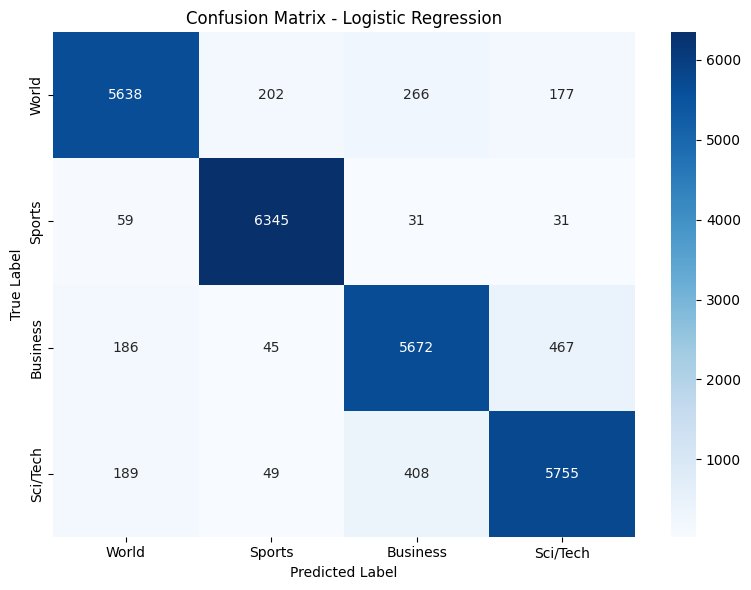

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

#  Optional: define class labels
labels = ["World", "Sports", "Business", "Sci/Tech"]  # Adjust if needed

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

RandomForest Classifier

In [ ]:
# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Classification report
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.8970219435736677
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      6283
           1       0.93      0.98      0.95      6466
           2       0.87      0.87      0.87      6370
           3       0.87      0.86      0.87      6401

    accuracy                           0.90     25520
   macro avg       0.90      0.90      0.90     25520
weighted avg       0.90      0.90      0.90     25520

Confusion Matrix:
 [[5539  264  279  201]
 [  65 6323   37   41]
 [ 208   93 5524  545]
 [ 250  136  509 5506]]


XGBoost Classifier

In [ ]:
# Initialize and train the model
xgb_model = XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:37:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9025862068965518
Confusion Matrix:
 [[5576  233  250  224]
 [  71 6299   34   62]
 [ 186   77 5552  555]
 [ 224  116  454 5607]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.90      6283
           1       0.94      0.97      0.96      6466
           2       0.88      0.87      0.88      6370
           3       0.87      0.88      0.87      6401

    accuracy                           0.90     25520
   macro avg       0.90      0.90      0.90     25520
weighted avg       0.90      0.90      0.90     25520



In [ ]:
joblib.dump(xgb_model, 'XGBOOST_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer(50000).pkl')
joblib.dump(model, 'LogisticRegressor_model.pkl')


['LogisticRegressor_model.pkl']

In [ ]:
def preprocess_article(article_text):
    cleaned = clean_text(article_text)
    vectorized = vectorizer.transform([cleaned])
    return vectorized

In [ ]:
def predict_article_category(article_text):
    # Define label-to-category mapping
    label_map = {
        0: "World",
        1: "Sports",
        2: "Business",
        3: "Sci/Tech"
    }

    # Preprocess and predict
    X_input = preprocess_article(article_text)
    prediction = xgb_model.predict(X_input)[0]

    # Return category name
    return label_map.get(prediction, "Unknown")
article = "NASA announces new mission to explore Jupiter's moons."
category = predict_article_category(article)
print("Predicted Category:", category)

Predicted Category: Sci/Tech


In [ ]:
#  Load and Prepare Dataset
texts = df['clean_text'].astype(str).tolist()
labels = df['label'].tolist()


#  Tokenize and Pad Sequences
tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=30, padding='post')

#  Encode Labels (one-hot for categorical_crossentropy)
y = to_categorical(labels, num_classes=4)

#  Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Build Model
model = Sequential([
    Embedding(input_dim=50000, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    LSTM(32),
    Dense(4, activation='softmax')  # 4 for number of classes
])

#  Compile Model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#  Training with Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    callbacks=[early_stop, lr_scheduler],
    batch_size=32
)

Epoch 1/5
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 451s 140ms/step - accuracy: 0.8321 - loss: 0.4516 - val_accuracy: 0.9134 - val_loss: 0.2614 - learning_rate: 0.0010
Epoch 2/5
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 499s 156ms/step - accuracy: 0.9403 - loss: 0.1846 - val_accuracy: 0.9166 - val_loss: 0.2485 - learning_rate: 0.0010
Epoch 3/5
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 449s 140ms/step - accuracy: 0.9591 - loss: 0.1246 - val_accuracy: 0.9111 - val_loss: 0.2935 - learning_rate: 0.0010
Epoch 4/5
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9715 - loss: 0.0827
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 444s 139ms/step - accuracy: 0.9715 - loss: 0.0828 - val_accuracy: 0.9074 - val_loss: 0.3445 - learning_rate: 0.0010
Epoch 5/5
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 491s 136ms/step - accuracy: 0.9842 - loss: 0.0458 - val_accuracy: 0.9049 - val_loss: 0.4002 - learning_rate: 5.0000e-04


In [ ]:


# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # Since you used one-hot encoding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Precision, Recall, F1 (per class + macro/micro averaging)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")

# Detailed Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

798/798 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step
Accuracy: 0.9165752351097178
Macro Precision: 0.9168
Macro Recall:    0.9163
Macro F1 Score:  0.9163

Classification Report:
               precision    recall  f1-score   support

           0     0.9394    0.8900    0.9140      6283
           1     0.9557    0.9779    0.9667      6466
           2     0.8800    0.9006    0.8902      6370
           3     0.8923    0.8966    0.8944      6401

    accuracy                         0.9166     25520
   macro avg     0.9168    0.9163    0.9163     25520
weighted avg     0.9169    0.9166    0.9165     25520


Confusion Matrix:
 [[5592  194  293  204]
 [  58 6323   53   32]
 [ 133   43 5737  457]
 [ 170   56  436 5739]]


798/798 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step


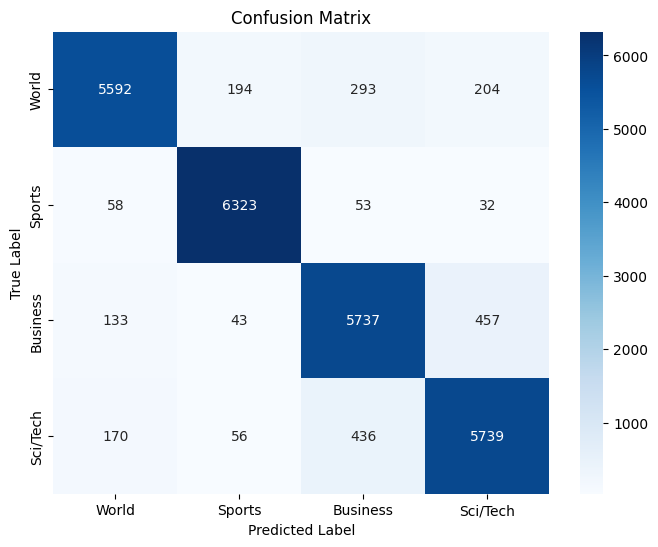

In [ ]:
# Convert one-hot labels to class indices
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels for the confusion matrix
class_labels = ["World", "Sports", "Business", "Sci/Tech"]

# Plot using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix




#  Build GRU Model
model1 = Sequential([
    Embedding(input_dim=50000, output_dim=128), # Ensure input_dim matches tokenizer's num_words
    Bidirectional(GRU(64, return_sequences=True)),
    Dropout(0.2),
    GRU(32),
    Dense(4, activation='softmax')  # 4 units for 4-class output
])

#  Compile Model
model1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#  Training with Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

model1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10, # Increased epochs
    batch_size=32,
    callbacks=[early_stop, lr_scheduler]
)


# Predict probabilities
y_pred_probs = model1.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # Since you used one-hot encoding

# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Precision, Recall, F1 (per class + macro/micro averaging)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")

# Detailed Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

Epoch 1/10
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 429s 133ms/step - accuracy: 0.7950 - loss: 0.4988 - val_accuracy: 0.9169 - val_loss: 0.2500 - learning_rate: 0.0010
Epoch 2/10
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 418s 131ms/step - accuracy: 0.9433 - loss: 0.1706 - val_accuracy: 0.9144 - val_loss: 0.2629 - learning_rate: 0.0010
Epoch 3/10
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 424s 133ms/step - accuracy: 0.9604 - loss: 0.1145 - val_accuracy: 0.9118 - val_loss: 0.2996 - learning_rate: 0.0010
Epoch 4/10
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9741 - loss: 0.0742
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 440s 132ms/step - accuracy: 0.9741 - loss: 0.0742 - val_accuracy: 0.9066 - val_loss: 0.3457 - learning_rate: 0.0010
798/798 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step
Accuracy: 0.9168887147335423
Macro Precision: 0.9171
Macro Recall:    0.9166
Macro F1 Score:  0.9166

Classification Report:
               precision    recall  f1-score 

798/798 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step


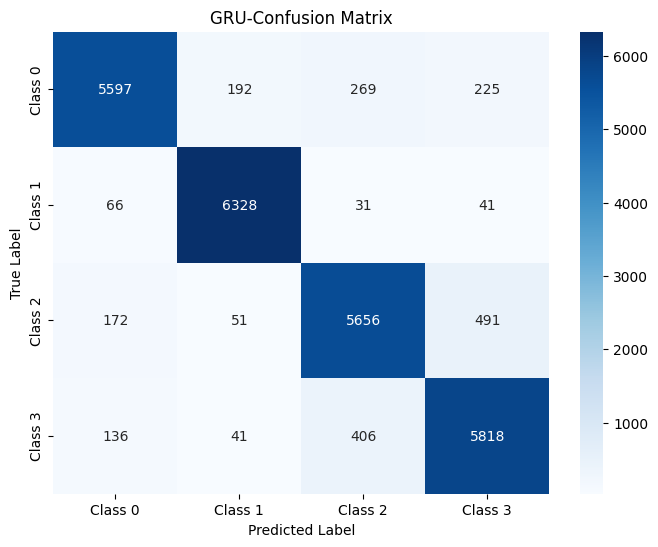

In [ ]:


# Convert one-hot labels to class indices
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model1.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(4)],
            yticklabels=[f'Class {i}' for i in range(4)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("GRU-Confusion Matrix")
plt.show()

In [ ]:
import joblib

joblib.dump(model1, "GRU_model.pkl")

['GRU_model.pkl']

In [ ]:
model1.save("GRU_model1.h5")

In [ ]:
from transformers import DistilBertModel

distilbert_encoder = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 127600 entries, 3 to 3
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Title        127600 non-null  object
 1   Description  127600 non-null  object
 2   text         127600 non-null  object
 3   label        127600 non-null  int64 
 4   label_id     127600 non-null  int64 
 5   clean_text   127600 non-null  object
dtypes: int64(2), object(4)
memory usage: 6.8+ MB


In [ ]:
!pip install --upgrade transformers

In [ ]:
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizerFast, TFDistilBertModel, DistilBertForSequenceClassification
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import tensorflow as tf
from transformers import TrainingArguments, Trainer
import evaluate
import pandas as pd
from datasets import Dataset # Added import for Dataset

# Assuming df, train_df, test_df are already loaded and processed as in previous cells
# Specifically, df['clean_text'] and df['label'] or train_df/test_df with 'text' and 'label'

# Ensure label_id is created and y is one-hot encoded
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_id'])

# Split data using clean_text and one-hot encoded labels
X_train_texts, X_test_texts, y_train_encoded, y_test_encoded = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

# Convert back to original labels for Hugging Face Dataset compatibility if needed later
y_train = np.argmax(y_train_encoded, axis=1)
y_test = np.argmax(y_test_encoded, axis=1)


# Create Hugging Face Datasets
# Need to ensure train_df and test_df exist or create temporary dataframes for the Trainer
# Based on previous cells, train_df and test_df should exist with 'text' and 'label' columns
# If not, you might need to create them from X_train_texts, y_train, X_test_texts, y_test
# For now, assuming train_df and test_df are available with the correct structure from previous successful runs

# If train_df and test_df with 'text' and 'label' are not directly available,
# you might need to reconstruct simplified dataframes for the Dataset.from_pandas step

# Example reconstruction if needed (adjust based on actual available data)
# train_data_dict = {'text': X_train_texts, 'label': y_train}
# test_data_dict = {'text': X_test_texts, 'label': y_test}
# train_df_for_hf = pd.DataFrame(train_data_dict)
# test_df_for_hf = pd.DataFrame(test_data_dict)


# Convert to HuggingFace Dataset (using the existing train_df and test_df if they have 'text' and 'label')
# Assuming train_df and test_df were correctly prepared in previous steps (like in ROBwgroDwRp8)
# If not, use the reconstructed dataframes:
# train_dataset = Dataset.from_pandas(train_df_for_hf)
# test_dataset  = Dataset.from_pandas(test_df_for_hf)

# A safer approach if train_df/test_df might not have the right columns after splits
train_dataset = Dataset.from_dict({'text': X_train_texts, 'label': y_train})
test_dataset = Dataset.from_dict({'text': X_test_texts, 'label': y_test})


# Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.remove_columns(["text"])
test_dataset  = test_dataset.remove_columns(["text"])

# Set format to PyTorch tensors (as Trainer works well with PyTorch)
train_dataset.set_format("torch")
test_dataset.set_format("torch")


# Model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4  # Your number of classes
)

# Metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)
    f1_score = f1.compute(predictions=preds, references=labels, average="weighted")
    return {"accuracy": acc["accuracy"], "f1": f1_score["f1"]}

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3, # Increased epochs slightly
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    push_to_hub=False,
    report_to="none" # Avoid reporting to external services if not needed
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the trained model
evaluation_results = trainer.evaluate()
print(evaluation_results)

Map:   0%|          | 0/102080 [00:00<?, ? examples/s]

Map:   0%|          | 0/25520 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3653917721.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming trainer and test_dataset are available from the previous cell (ROBwgroDwRp8)
# Get predictions from the trained model
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(4, 3))  # Small size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

NameError: name 'trainer' is not defined

In [ ]:


#  Encode labels
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_id'])

#  Split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Tokenize with fixed padding
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(
    X_train_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_encodings = tokenizer(
    X_test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

#  DistilBERT encoder
def distilbert_encoder():
    bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

    def extract_cls_token(inputs):
        input_ids, attention_mask = inputs
        output = bert_model(input_ids, attention_mask=attention_mask)
        cls_token = output.last_hidden_state[:, 0, :]  # CLS token
        return cls_token

    return Lambda(extract_cls_token, output_shape=(768,))

#  Build model
input_ids = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(128,), dtype='int32', name='attention_mask')

cls_output = distilbert_encoder()([input_ids, attention_mask])
output = Dense(y_train.shape[1], activation='softmax')(cls_output)

model2 = Model(inputs=[input_ids, attention_mask], outputs=output)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#  Train
model2.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([test_encodings['input_ids'], test_encodings['attention_mask']], y_test),
    epochs=3,
    batch_size=32
)

# Evaluate
y_pred_probs = model2.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))


In [ ]:
!pip install transformers==4.54.1

In [ ]:

df['label_id'] = LabelEncoder().fit_transform(df['label'])
y = to_categorical(df['label_id'])

#  Train-test split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='tf'
    )

train_encodings = tokenize(X_train_texts)
test_encodings = tokenize(X_test_texts)


bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")


def get_cls_embeddings_batched(encodings, batch_size=32):
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    num_samples = input_ids.shape[0]

    cls_embeddings = []

    for i in range(0, num_samples, batch_size):
        batch_input_ids = input_ids[i:i+batch_size]
        batch_attention_mask = attention_mask[i:i+batch_size]

        outputs = bert_model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask
        )
        cls_batch = outputs.last_hidden_state[:, 0, :]
        cls_embeddings.append(cls_batch)

    return tf.concat(cls_embeddings, axis=0)


X_train_embed = get_cls_embeddings_batched(train_encodings, batch_size=32)
X_test_embed = get_cls_embeddings_batched(test_encodings, batch_size=32)


input_layer = Input(shape=(768,))
output_layer = Dense(y_train.shape[1], activation='softmax')(input_layer)
classifier = Model(inputs=input_layer, outputs=output_layer)

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


classifier.fit(X_train_embed, y_train, validation_data=(X_test_embed, y_test), epochs=10, batch_size=32)



# Evaluate
y_pred_probs = classifier.predict(X_test_embed)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


In [ ]:
# 💾 Save model
classifier.save("bert_classifier.h5")

In [ ]:

label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_id'])

#  Split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Tokenize with BERT
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(
    X_train_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_encodings = tokenizer(
    X_test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

#  BERT encoder
def bert_encoder():
    bert_model = TFBertModel.from_pretrained("bert-base-uncased")

    def extract_cls_token(inputs):
        input_ids, attention_mask = inputs
        output = bert_model(input_ids, attention_mask=attention_mask)
        cls_token = output.last_hidden_state[:, 0, :]  # CLS token
        return cls_token

    return Lambda(extract_cls_token, output_shape=(768,))

# Build model
input_ids = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(128,), dtype='int32', name='attention_mask')

cls_output = bert_encoder()([input_ids, attention_mask])
output = Dense(y_train.shape[1], activation='softmax')(cls_output)

model3 = Model(inputs=[input_ids, attention_mask], outputs=output)
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model3.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([test_encodings['input_ids'], test_encodings['attention_mask']], y_test),
    epochs=3,
    batch_size=32
)


y_pred_probs = model3.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [ ]:
plt.figure(figsize=(4, 3))  # Small size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
model2.save("transformer_bert-base-uncased_model.h5")

In [ ]:
model_bert.save("transformer_fine_tuned_bert_model.h5")

In [ ]:


#  Encode labels
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])  # 'label' column should contain category names
y = to_categorical(df['label_id'])

#  Split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Tokenize with RoBERTa
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

train_encodings = tokenizer(
    X_train_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_encodings = tokenizer(
    X_test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

# RoBERTa encoder
def roberta_encoder():
    roberta_model = TFRobertaModel.from_pretrained("roberta-base")

    def extract_cls_token(inputs):
        input_ids, attention_mask = inputs
        output = roberta_model(input_ids, attention_mask=attention_mask)
        cls_token = output.last_hidden_state[:, 0, :]  # CLS token
        return cls_token

    return Lambda(extract_cls_token, output_shape=(768,))

#  Build model
input_ids = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(128,), dtype='int32', name='attention_mask')

cls_output = roberta_encoder()([input_ids, attention_mask])
output = Dense(y_train.shape[1], activation='softmax')(cls_output)

model_roberta = Model(inputs=[input_ids, attention_mask], outputs=output)
model_roberta.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#  Train
history = model_roberta.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([test_encodings['input_ids'], test_encodings['attention_mask']], y_test),
    epochs=3,
    batch_size=32
)

#  Evaluate
y_pred_probs = model_roberta.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [ ]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
model2.save("transformer_roberta_model.h5")

In [ ]:


#  Encode labels
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_id'])

#  Split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Load tokenizer from fine-tuned model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

#  Tokenize
train_encodings = tokenizer(
    X_train_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_encodings = tokenizer(
    X_test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

from transformers import TFAutoModel

# Load base BERT model without classification head
base_model = TFAutoModel.from_pretrained(model_name)

from tensorflow.keras.layers import Lambda

# Inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Lambda wrapper with explicit output shape
def bert_layer(inputs):
    input_ids, attention_mask = inputs
    bert_output = base_model(input_ids, attention_mask=attention_mask)[0]
    return bert_output[:, 0, :]  # [CLS] token

cls_token = Lambda(
    bert_layer,
    output_shape=(base_model.config.hidden_size,)
)([input_ids, attention_mask])

# Classification head
output = Dense(y_train.shape[1], activation='softmax')(cls_token)

# Final model
model_bert2 = Model(inputs=[input_ids, attention_mask], outputs=output)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)

model_bert2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#  Train
history = model_bert2.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([test_encodings['input_ids'], test_encodings['attention_mask']], y_test),
    epochs=3,
    batch_size=32
)

#  Evaluate
y_pred_probs = model_bert2.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Accuracy:", accuracy_score(y_true, y_pred))
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [ ]:


#  Encode labels
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_id'])

# Split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Load tokenizer from fine-tuned model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

#  Tokenize
train_encodings = tokenizer(
    X_train_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_encodings = tokenizer(
    X_test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

from transformers import TFAutoModel


base_model = TFAutoModel.from_pretrained(model_name)

from tensorflow.keras.layers import Lambda

# Inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Lambda wrapper with explicit output shape
def bert_layer(inputs):
    input_ids, attention_mask = inputs
    bert_output = base_model(input_ids, attention_mask=attention_mask)[0]
    return bert_output[:, 0, :]  # [CLS] token

cls_token = Lambda(
    bert_layer,
    output_shape=(base_model.config.hidden_size,)
)([input_ids, attention_mask])

# Classification head
output = Dense(y_train.shape[1], activation='softmax')(cls_token)

# Final model
model_bert = Model(inputs=[input_ids, attention_mask], outputs=output)
model_bert.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# 🏋️ Train
history = model_bert.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([test_encodings['input_ids'], test_encodings['attention_mask']], y_test),
    epochs=3,
    batch_size=64
)

# 📊 Evaluate
y_pred_probs = model_bert.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Accuracy:", accuracy_score(y_true, y_pred))
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [ ]:
plt.figure(figsize=(4, 3))  # Small size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:

#  Encode labels
label_encoder = LabelEncoder()
df['label_id'] = label_encoder.fit_transform(df['label'])
y = to_categorical(df['label_id'])

#  Split data
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    df['clean_text'].tolist(), y, test_size=0.2, stratify=y, random_state=42
)

#  Load tokenizer from fine-tuned model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)

#  Tokenize
train_encodings = tokenizer(
    X_train_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

test_encodings = tokenizer(
    X_test_texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

from transformers import TFAutoModel

base_model = TFAutoModel.from_pretrained(
    model_name,
    from_pt=True
)


from tensorflow.keras.layers import Lambda

# Inputs
input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Lambda wrapper with explicit output shape
def bert_layer(inputs):
    input_ids, attention_mask = inputs
    bert_output = base_model(input_ids, attention_mask=attention_mask)[0]
    return bert_output[:, 0, :]  # [CLS] token

cls_token = Lambda(
    bert_layer,
    output_shape=(base_model.config.hidden_size,)
)([input_ids, attention_mask])

# Classification head
output = Dense(y_train.shape[1], activation='softmax')(cls_token)

# Final model
model_bert = Model(inputs=[input_ids, attention_mask], outputs=output)
model_bert.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])





# Train
history = model_bert.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([test_encodings['input_ids'], test_encodings['attention_mask']], y_test),
    epochs=10,
    batch_size=32
)


#  Evaluate
y_pred_probs = model_bert.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Accuracy:", accuracy_score(y_true, y_pred))
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall:    {recall:.4f}")
print(f"Macro F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(4, 3))  # Small size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [ ]:
import joblib

joblib.dump(model_bert, "transformer_bert(epoch=10)_model.pkl")

In [ ]:
model_bert.save("transformer_bert(epoch=10)_model.h5")

In [ ]:
from tabulate import tabulate

# Define the data
headers = ["Model Name", "Model Type", "Accuracy", "F1-Score", "Pros", "Cons"]
rows = [
    [
        "Logistic Regression", "ML", 0.90, 0.90,
        "1. Fast training and inference\n2. Easy to interpret and implement\n3. Good for linearly separable text",
        "1. Limited to linear decision boundaries\n2. Poor performance on long or complex text\n3. Requires manual feature engineering"
    ],
    [
        "GRU", "DL", 0.90, 0.90,
        "1. Captures sequential dependencies\n2. Handles variable-length input\n3. Suitable for moderately complex NLP tasks",
        "1. Slower training than ML models\n2. Sensitive to vanishing gradients\n3. Needs careful hyperparameter tuning"
    ],
    [
        "DistilBERT", "Pre-trained", 0.89, 0.89,
        "1. Excellent contextual understanding\n2. Pre-trained on large corpora\n3. High accuracy with fine-tuning",
        "1. High memory and compute requirements\n2. Slower inference speed\n3. May overfit on small datasets"
    ]
]

# Print the table
print("News Article Classifier Comparison:\n")
print(tabulate(rows, headers=headers, tablefmt="grid"))